# Create MNE events

This code is implemented in the section called "MNE EVENT CREATION FUNCTIONS" in the pipeline.py file.

This notebook is a step by step guide (in fact that's the way the collection of functions was created).

## 1. Import libraries and load data

In [9]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pyxdf
import sys

In [10]:
def get_stream_by_name(streams, stream_name):
    for stream in streams:
        if stream['info']['name'][0] == stream_name:
            return stream
    raise ValueError(f"Stream '{stream_name}' not found in XDF data.")

In [11]:
subject = 'dani'
task = 'stroop'
run = '002'

raw_filename = rf"C:\Users\adoni\Documents\CurrentStudy\data\sub-{subject}\ses-S001\raw\sub-{subject}_ses-S001_task-{task}_run-{run}_raw.fif"
xdf_filename = rf"C:\Users\adoni\Documents\CurrentStudy\data\sub-{subject}\ses-S001\xdf\sub-{subject}_ses-S001_task-{task}_run-{run}.xdf"
streams, header = pyxdf.load_xdf(xdf_filename, verbose=True)
raw = mne.io.read_raw_fif(raw_filename, preload=True)

Opening raw data file C:\Users\adoni\Documents\CurrentStudy\data\sub-dani\ses-S001\raw\sub-dani_ses-S001_task-stroop_run-002_raw.fif...
    Range : 0 ... 41471 =      0.000 ...   161.996 secs
Ready.
Reading 0 ... 41471  =      0.000 ...   161.996 secs...


## 2. Creating events from XDF streams

### 2.1. Cleaning the markers

We will be working on the stream called "PsychoPyMarkers", so we need to declare it as a variable for working better.

In [12]:
stroop_stream = get_stream_by_name(streams, 'PsychoPyMarkers')
stroop_tstamps = stroop_stream['time_stamps']
stroop_tseries = stroop_stream['time_series']
print('length of time stamps:', len(stroop_tstamps))
print('length of time series:', len(stroop_tseries))

length of time stamps: 96
length of time series: 96


I want to delete the "TRIAL_START" marker because its not useful

In [13]:
idx_to_del = [i for i, ts in enumerate(stroop_tseries) if ts[0] == 'TRIAL_START']

# Elimina primero de mayor a menor para no desordenar los índices
for i in sorted(idx_to_del, reverse=True):
    stroop_tseries.pop(i)
    stroop_tstamps = np.delete(stroop_tstamps, i)

print("length of time stamps after deleting 'TRIAL_START':", len(stroop_tstamps))
print("length of time series after deleting 'TRIAL_START':", len(stroop_tseries))

length of time stamps after deleting 'TRIAL_START': 66
length of time series after deleting 'TRIAL_START': 66


Let's take a look of our markers

In [14]:
for i in range(len(stroop_tstamps[:10])):
    print(round(stroop_tstamps[i], 2),':', stroop_tseries[i][0])

33166.1 : EXPERIMENT_START
33167.09 : INSTRUCTIONS_ONSET
33173.26 : WORD_ONSET_verde_blue_Not_Congruent
33174.34 : RESPONSE_right_Correct
33174.87 : WORD_ONSET_rojo_green_Not_Congruent
33175.96 : RESPONSE_down_Correct
33176.49 : WORD_ONSET_rojo_red_Congruent
33177.17 : RESPONSE_left_Correct
33177.71 : WORD_ONSET_azul_blue_Congruent
33178.76 : RESPONSE_right_Correct


### 2.2. Converting time to relative 

In [15]:
eeg_stream = get_stream_by_name(streams, 'eeg_eeg')
first_eeg_timestamp = eeg_stream['time_stamps'][0]
first_eeg_timestamp

np.float64(33154.4372893052)

The first_timestamp in your data starts at a value that is not zero because it represents the absolute time (in seconds) since the start of the recording session. The timestamp is relative to when the device/software started recording, not reset to zero for each new recording.

The first timestamp is not zero because it marks the time (in seconds) since the recording system started, not the start of your specific data segment. To get relative times for your experiment, subtract the first_timestamp from all timestamps.

In [23]:
stroop_tstamps = stroop_tstamps - first_eeg_timestamp

In [24]:
for i in range(len(stroop_tstamps)):
    print(round(stroop_tstamps[i], 2),':', stroop_tseries[i][0])

11.66 : EXPERIMENT_START
12.65 : INSTRUCTIONS_ONSET
18.82 : WORD_ONSET_verde_blue_Not_Congruent
19.9 : RESPONSE_right_Correct
20.43 : WORD_ONSET_rojo_green_Not_Congruent
21.52 : RESPONSE_down_Correct
22.05 : WORD_ONSET_rojo_red_Congruent
22.74 : RESPONSE_left_Correct
23.27 : WORD_ONSET_azul_blue_Congruent
24.32 : RESPONSE_right_Correct
24.86 : WORD_ONSET_azul_red_Not_Congruent
25.57 : RESPONSE_left_Correct
26.11 : WORD_ONSET_verde_green_Congruent
27.17 : RESPONSE_down_Correct
27.71 : WORD_ONSET_verde_blue_Not_Congruent
28.48 : RESPONSE_right_Correct
29.01 : WORD_ONSET_rojo_green_Not_Congruent
30.11 : RESPONSE_down_Correct
30.64 : WORD_ONSET_azul_blue_Congruent
31.59 : RESPONSE_right_Correct
32.13 : WORD_ONSET_rojo_red_Congruent
32.73 : RESPONSE_left_Correct
33.26 : WORD_ONSET_azul_red_Not_Congruent
34.08 : RESPONSE_left_Correct
34.61 : WORD_ONSET_verde_green_Congruent
35.86 : RESPONSE_down_Correct
36.4 : WORD_ONSET_rojo_green_Not_Congruent
37.13 : RESPONSE_down_Correct
37.66 : WORD_ONS

We want to get the firtst time stamp of the EEG recording

In [25]:
eeg_tstamps = eeg_stream['time_stamps']
eeg_tstamps[0]

np.float64(33154.4372893052)

Another way of getting this information is this:

In [26]:
eeg_stream['footer']['info']['first_timestamp']

['33154.45307775']

But the time stamps are not equal

In [27]:
eeg_stream['time_stamps'][0] == float(eeg_stream['footer']['info']['first_timestamp'][0])

np.False_

Why?

In [28]:
eeg_stream['time_stamps'][0] - float(eeg_stream['footer']['info']['first_timestamp'][0])

np.float64(-0.015788444798090495)

The values are not the same, I will use this: DaniEEGData.eeg_stream['time_stamps'][0] 

As is the one that lefts the eeg_tstamps okay relative to zero

In [29]:
eeg_tstamps = eeg_tstamps - eeg_stream['time_stamps'][0]
eeg_tstamps[0]

np.float64(0.0)

Let's see our first Stroop time stamp now that the time is relative to the start of the EEG recording.

In [30]:
stroop_tstamps[0]

np.float64(11.663917466212297)

This means the Stroop started ~12 seconds after the EEG started collectiong data

### 2.3. Building the Event object

The Events object from MNE is an array with this information:

1. The first column contains the event onset (in samples)
2. In most cases, the second column is all zeros and can be ignored. 
3. The last column contains the event code.

The shape of the array is (n_events, 3)

This means, it has three dimensions and the length is the number of events registered, in our case 66.

#### 2.2.1. Building the dim1: event onset

So firstly, let's find the number of sample in the EEG timestamps that corresponds to the Stroop marker time stamp. 

In [31]:
round(stroop_tstamps[0], 5)

np.float64(11.66392)

In [32]:
print(round(eeg_tstamps[2986],5))
print(round(eeg_tstamps[2987],5))
print(round(eeg_tstamps[2988],5))
print('-'*10)
print(round(eeg_tstamps[3237],5))
print(round(eeg_tstamps[3238],5))
print(round(eeg_tstamps[3239],5))

11.66365
11.66756
11.67146
----------
12.64408
12.64799
12.6519


The problem is that there is no value in the eeg time stamps equal to the value in the stroop time stamps

In [33]:
print(eeg_tstamps[3236] - stroop_tstamps[1])
print(eeg_tstamps[3237] - stroop_tstamps[1])
print(eeg_tstamps[3238] - stroop_tstamps[1])
print(eeg_tstamps[3239] - stroop_tstamps[1])


-0.008048917814448941
-0.004142806224990636
-0.0002366946282563731
0.0036694169612019323


We will have to assing the time stamp index that with the minimun difference.
We can also store that differences.

In [34]:
stroop_start_index = -1
for i in range(len(eeg_tstamps)):
    diff = stroop_tstamps[0] - eeg_tstamps[i]
    if abs(diff) <= 0.0003:
        stroop_start_index = i
        print('First stroop word index estimated in eeg timestamps:', i)
        break

First stroop word index estimated in eeg timestamps: 2986


So if we add that differente to the eeg time stamp we will get the real stroop time stamp

In [35]:
print('Real first stroop timestamp     :', stroop_tstamps[0])
print('Estimated first stroop timestamp:', eeg_tstamps[stroop_start_index] + diff)

Real first stroop timestamp     : 11.663917466212297
Estimated first stroop timestamp: 11.663917466212297


Just to check

In [36]:
eeg_tstamps[stroop_start_index] + diff == stroop_tstamps[0]

np.True_

In [37]:
stroop_start_index

2986

We can now start to assing eeg indices to the markers saved in the PsychopyMarkers streams. We do this because the `Event` object of MNE has this structure:

ndarry of int, shape (n_events, 3)

1. The first column contains the event onset (in samples)
2. In most cases, the second column is all zeros and can be ignored. 
3. The last column contains the event code.

We have to get the sample number related to the time stamp where the Marker ocurrs

In [38]:
index = stroop_start_index
stroop_indexes = []
diffs = []
for e1 in stroop_tstamps:
    for e2 in eeg_tstamps[index:]:
        diff = e1 - e2
        if diff <= 0.0003:
            stroop_indexes.append(index)
            diffs.append(diff)
            break
        index += 1

Just to check our stroop indexes are the same as the length of our stroop markers

In [39]:
print('stroop indexes length:', len(stroop_indexes))

stroop indexes length: 66


#### 2.2.2. Building the dim3: event dict

Now lets assing codes to each event type. We have two major events we want to code:
1. Stimuli
2. Responses

And we can also classify the stimulus and the responses in two clases:
1. Stimulus
   1. Congruent = 1
   2. Not congruent = 2
2. Responses
   1. Correct = 3
   2. Incorrect = 4

But we will only assing two codes for the moment: stimulus and response.

In [40]:
stroop_event_codes = []

for i in range(len(stroop_tseries)):
    if 'WORD_ONSET' in stroop_tseries[i][0]:
        stroop_event_codes.append(1)
    elif 'RESPONSE' in stroop_tseries[i][0]:
        stroop_event_codes.append(2)
    else:
        stroop_event_codes.append(0)

In [42]:
stroop_event_codes = []

for i in range(len(stroop_tseries)):
    if 'WORD_ONSET' in stroop_tseries[i][0]:
        if 'Not_Congruent' in stroop_tseries[i][0]:
            stroop_event_codes.append(2)
        else:
            stroop_event_codes.append(1)
    elif 'RESPONSE' in stroop_tseries[i][0]:
        if 'Correct' in stroop_tseries[i][0]:
            stroop_event_codes.append(3)
        elif 'Incorrect' in stroop_tseries[i][0]:
            stroop_event_codes.append(4)
    else:
        stroop_event_codes.append(0)

In [43]:
len(stroop_event_codes)

66

#### 3.3.3. Wrapping up all the dimensions

Now we can create it, merging the three dimensions

In [45]:
# Create a ndarry of int, shape (n_events, 3)
# The first column contains the event onset (in samples)
# In most cases, the second column is all zeros and can be ignored. 
# The last column contains the event code.

stroop_events = np.zeros((len(stroop_tstamps), 3), dtype=int)
stroop_events[:, 0] = stroop_indexes
stroop_events[:, 2] = stroop_event_codes

### 2.4. Save and load

Let's save it

In [46]:
sub = 'dani'
extension = '.fif'
file_path = rf'C:\Users\adoni\Documents\CurrentStudy\data\sub-{sub}\ses-S001\events\sub-{sub}_ses-S001_task-{task}_run-{run}_eve{extension}'
mne.write_events(filename=file_path, events=stroop_events, overwrite=True)

Overwriting existing file.


And let's open it

In [47]:
file_path = rf'C:\Users\adoni\Documents\CurrentStudy\data\sub-{subject}\ses-S001\events\sub-{subject}_ses-S001_task-{task}_run-{run}_eve.fif'
events_from_xdf = mne.read_events(file_path)
events_from_xdf

array([[ 2986,     0,     0],
       [ 3238,     0,     0],
       [ 4818,     0,     2],
       [ 5096,     0,     3],
       [ 5232,     0,     2],
       [ 5510,     0,     3],
       [ 5646,     0,     1],
       [ 5821,     0,     3],
       [ 5958,     0,     1],
       [ 6227,     0,     3],
       [ 6364,     0,     2],
       [ 6547,     0,     3],
       [ 6684,     0,     1],
       [ 6957,     0,     3],
       [ 7094,     0,     2],
       [ 7290,     0,     3],
       [ 7427,     0,     2],
       [ 7709,     0,     3],
       [ 7845,     0,     1],
       [ 8089,     0,     3],
       [ 8225,     0,     1],
       [ 8379,     0,     3],
       [ 8516,     0,     2],
       [ 8725,     0,     3],
       [ 8861,     0,     1],
       [ 9182,     0,     3],
       [ 9318,     0,     2],
       [ 9506,     0,     3],
       [ 9643,     0,     1],
       [ 9839,     0,     3],
       [ 9976,     0,     2],
       [10147,     0,     3],
       [10283,     0,     1],
       [10

### Plotting events

In [48]:
event_dict = {
    'WORD_CONGRUENT': 1,
    'WORD_NOT_CONGRUENT': 2,
    'RESPONSE_CORRECT': 3,
    #'RESPONSE_INCORRECT': 4
}

C:\Users\adoni\AppData\Local\Temp\ipykernel_15968\1500998044.py:1: RuntimeWarning: event 0 missing from event_id will be ignored
  fig = mne.viz.plot_events(


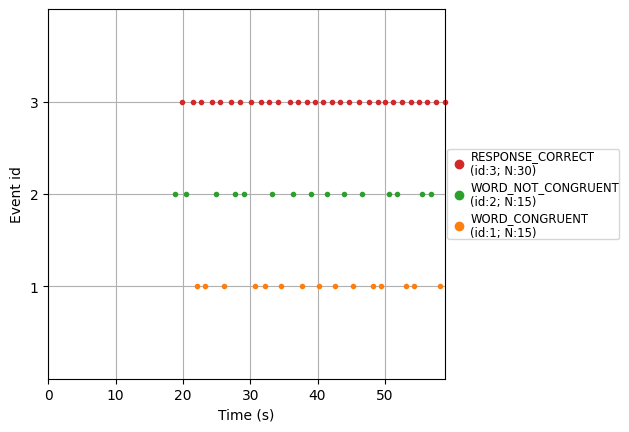

In [49]:
fig = mne.viz.plot_events(
    events_from_xdf, sfreq=raw.info["sfreq"], first_samp=raw.first_samp, event_id=event_dict
)

### Plotting events and raw data together

Events + annotations

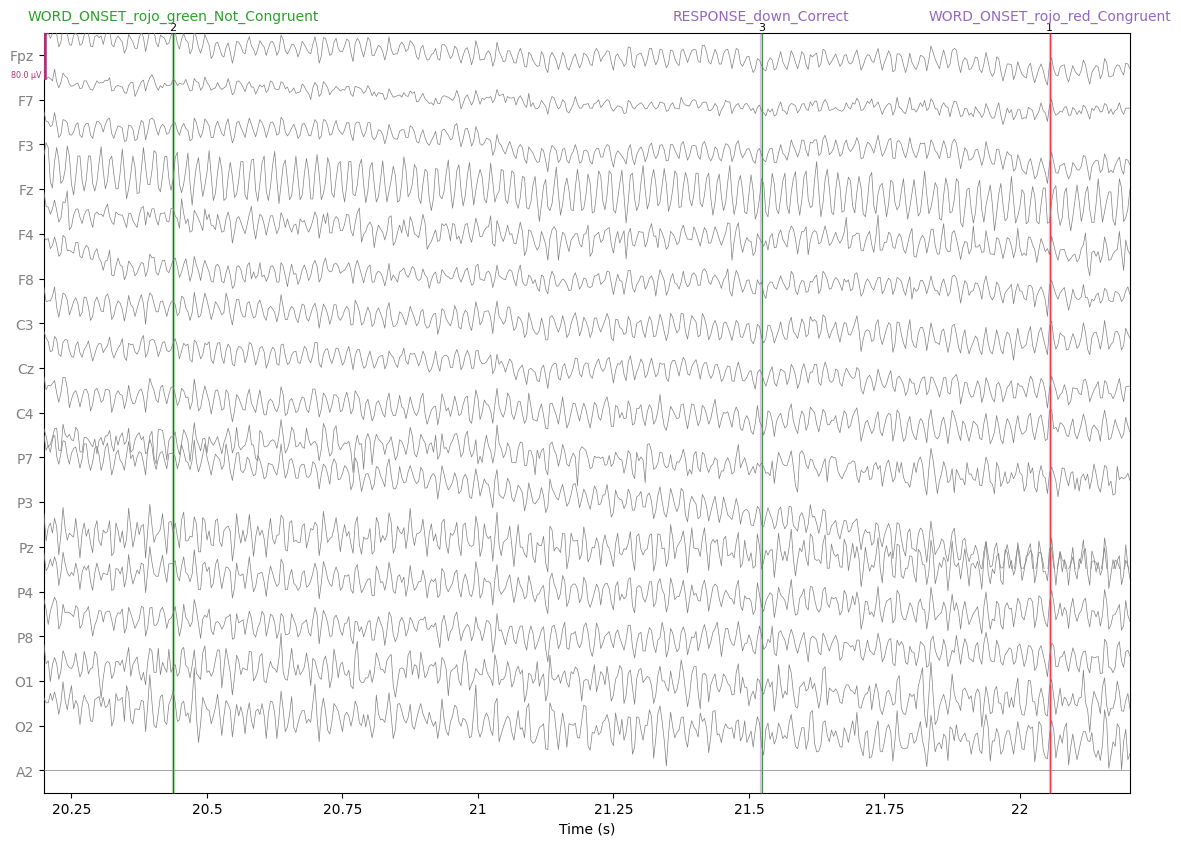

In [56]:
raw.plot(
    events=events_from_xdf,
    start=20.2,
    duration=2,
    color="gray",
    event_color={1: "r", 2: "b", 3: "g"},
    scalings=0.00004,
    show_scrollbars=False
);

## 3. Creating events from annotations

### 3.0. Plotting just annotations

`time_series` contiene las anotaciones en texto
`time_stamps` contiene el momento en que occurieron

In [57]:
raw.annotations

<Annotations | 66 segments: (1), EXPERIMENT_START (1), INSTRUCTIONS_ONSET ...>

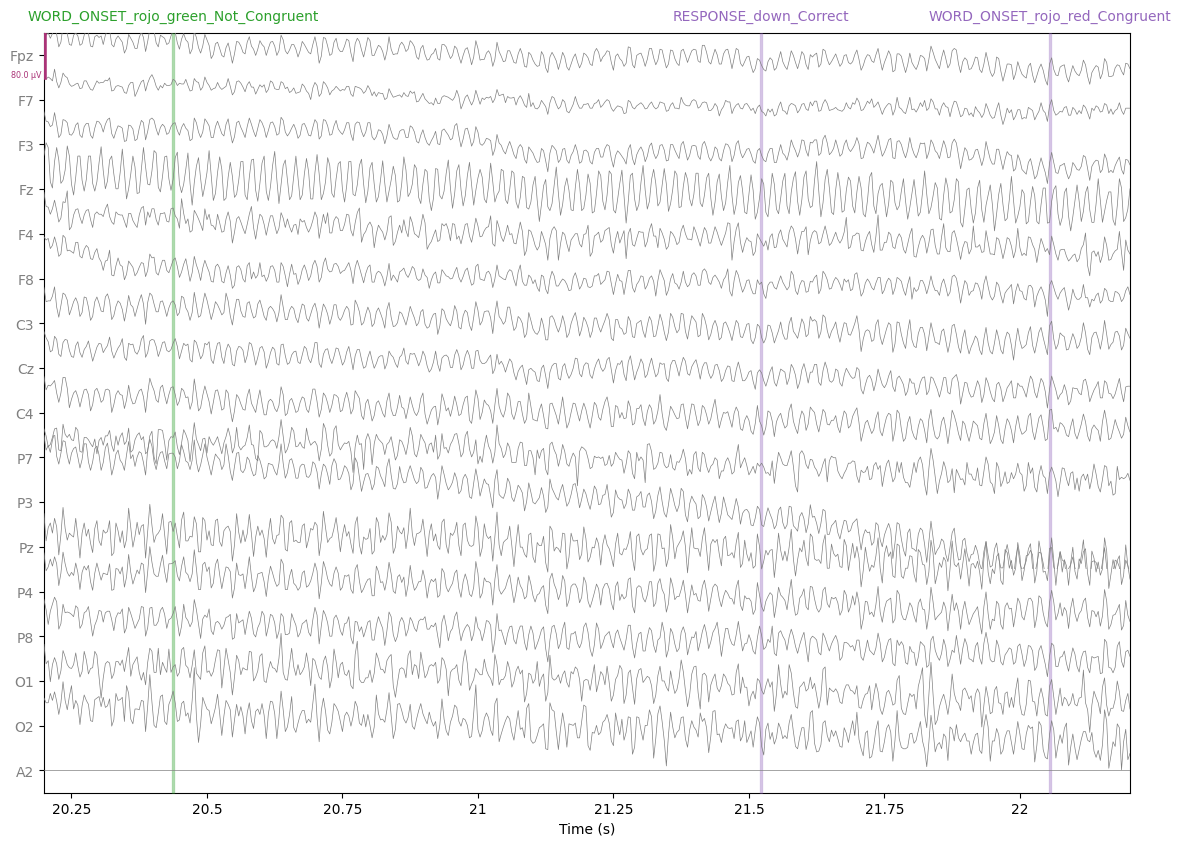

In [58]:
raw.plot(
    start=20.2,
    duration=2,
    color="gray",
    event_color={1: "r", 2: "b"},
    scalings=0.00004,
    show_scrollbars=False
);

### 3.1. Create events from annotations

Another way of creating events is creating them from annotations

In [59]:
events, events_dict = mne.events_from_annotations(raw)

Used Annotations descriptions: [np.str_(''), np.str_('EXPERIMENT_START'), np.str_('INSTRUCTIONS_ONSET'), np.str_('RESPONSE_down_Correct'), np.str_('RESPONSE_left_Correct'), np.str_('RESPONSE_right_Correct'), np.str_('THANKS_END'), np.str_('THANKS_START'), np.str_('TRIAL_END'), np.str_('WORD_ONSET_azul_blue_Congruent'), np.str_('WORD_ONSET_azul_red_Not_Congruent'), np.str_('WORD_ONSET_rojo_green_Not_Congruent'), np.str_('WORD_ONSET_rojo_red_Congruent'), np.str_('WORD_ONSET_verde_blue_Not_Congruent'), np.str_('WORD_ONSET_verde_green_Congruent')]


Let's take a look

In [60]:
events[:10]

array([[2986,    0,    2],
       [3238,    0,    3],
       [4817,    0,   14],
       [5095,    0,    6],
       [5231,    0,   12],
       [5509,    0,    4],
       [5646,    0,   13],
       [5821,    0,    5],
       [5957,    0,   10],
       [6226,    0,    6]])

### 3.2. The Event Dictionary

MNE then assigns each unique event code an integer value. This mapping between original event codes and integers is stored in a dictionary called events_dict

In [101]:
events_dict

{np.str_(''): 1,
 np.str_('EXPERIMENT_START'): 2,
 np.str_('INSTRUCTIONS_ONSET'): 3,
 np.str_('RESPONSE_down_Correct'): 4,
 np.str_('RESPONSE_left_Correct'): 5,
 np.str_('RESPONSE_right_Correct'): 6,
 np.str_('THANKS_END'): 7,
 np.str_('THANKS_START'): 8,
 np.str_('TRIAL_END'): 9,
 np.str_('WORD_ONSET_azul_blue_Congruent'): 10,
 np.str_('WORD_ONSET_azul_red_Not_Congruent'): 11,
 np.str_('WORD_ONSET_rojo_green_Not_Congruent'): 12,
 np.str_('WORD_ONSET_rojo_red_Congruent'): 13,
 np.str_('WORD_ONSET_verde_blue_Not_Congruent'): 14,
 np.str_('WORD_ONSET_verde_green_Congruent'): 15}

We can define a dictionary that maps labels onto each (original) event code of interest

In [123]:
event_mapping = {
    'word_onset_congruent': 101,
    'word_onset_not_congruent': 102,
    'response_correct': 99
}

In [118]:
dim1 = events[:, 0]
dim2 = np.zeros(len(events), dtype=int)
dim3 = events[:, 2]

In [119]:
print(dim3)

[ 2  3 14  6 12  4 13  5 10  6 11  5 15  4 14  6 12  4 10  6 13  5 11  5
 15  4 12  4 10  6 11  5 13  5 14  6 15  4 12  4 10  6 14  6 15  4 13  5
 11  5 12  4 15  4 10  6 11  5 14  6 13  5  9  8  7  1]


In [120]:
np.place(dim3, dim3 == 2, 0)
np.place(dim3, dim3 == 3, 0)
np.place(dim3, dim3 == 7, 0)
np.place(dim3, dim3 == 8, 0)
np.place(dim3, dim3 == 9, 0)
for number in [4, 5, 6]:
    np.place(dim3, dim3 == number, 99)

for number in [10, 13, 15]:
    np.place(dim3, dim3 == number, 101)

for number in [11, 12, 14]:
    np.place(dim3, dim3 == number, 102)

In [121]:
print(dim3)

[  0   0 102  99 102  99 101  99 101  99 102  99 101  99 102  99 102  99
 101  99 101  99 102  99 101  99 102  99 101  99 102  99 101  99 102  99
 101  99 102  99 101  99 102  99 101  99 101  99 102  99 102  99 101  99
 101  99 102  99 102  99 101  99   0   0   0   1]


In [122]:
events = np.array([dim1, dim2, dim3]).T
events

array([[ 2986,     0,     0],
       [ 3238,     0,     0],
       [ 4817,     0,   102],
       [ 5095,     0,    99],
       [ 5231,     0,   102],
       [ 5509,     0,    99],
       [ 5646,     0,   101],
       [ 5821,     0,    99],
       [ 5957,     0,   101],
       [ 6226,     0,    99],
       [ 6363,     0,   102],
       [ 6547,     0,    99],
       [ 6683,     0,   101],
       [ 6957,     0,    99],
       [ 7093,     0,   102],
       [ 7290,     0,    99],
       [ 7426,     0,   102],
       [ 7708,     0,    99],
       [ 7844,     0,   101],
       [ 8088,     0,    99],
       [ 8224,     0,   101],
       [ 8378,     0,    99],
       [ 8515,     0,   102],
       [ 8724,     0,    99],
       [ 8861,     0,   101],
       [ 9181,     0,    99],
       [ 9318,     0,   102],
       [ 9506,     0,    99],
       [ 9642,     0,   101],
       [ 9839,     0,    99],
       [ 9975,     0,   102],
       [10146,     0,    99],
       [10282,     0,   101],
       [10

We now need to map between events_dict and event_mapping.

C:\Users\adoni\AppData\Local\Temp\ipykernel_21104\416257500.py:3: RuntimeWarning: event 0 missing from event_id will be ignored
  mne.viz.plot_events(events, raw.info['sfreq'],
C:\Users\adoni\AppData\Local\Temp\ipykernel_21104\416257500.py:3: RuntimeWarning: event 1 missing from event_id will be ignored
  mne.viz.plot_events(events, raw.info['sfreq'],


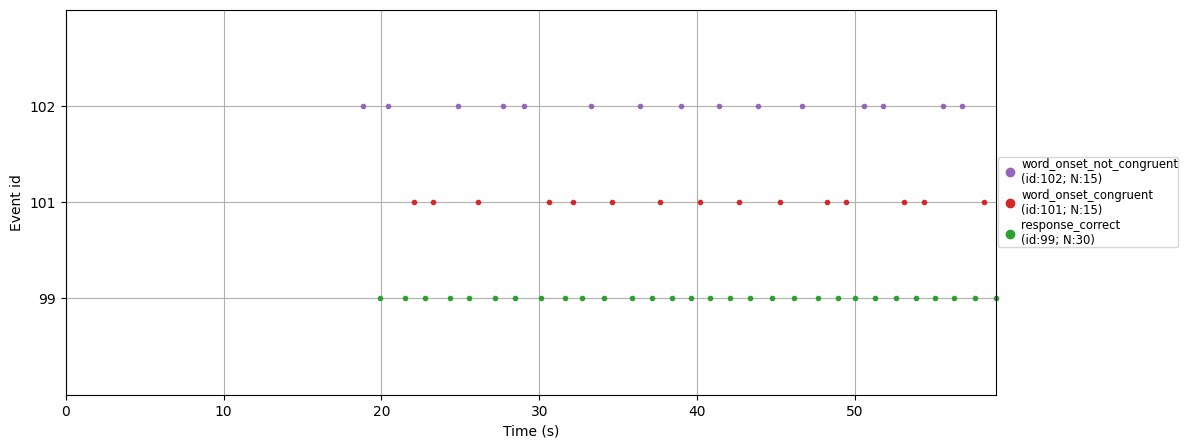

In [124]:
fig, ax = plt.subplots(figsize=[15, 5])

mne.viz.plot_events(events, raw.info['sfreq'],  
                    event_id=event_mapping,                    
                    axes=ax)
plt.show()

## 4. Differences between events created by annotations and mine

I think we can appreciate the tiny difference between the events and the annotations. I think its the same difference we got from parsing timestamp indexes between eeg stream and stroop streams.

eve_from_ann = 
eve_from_me = 

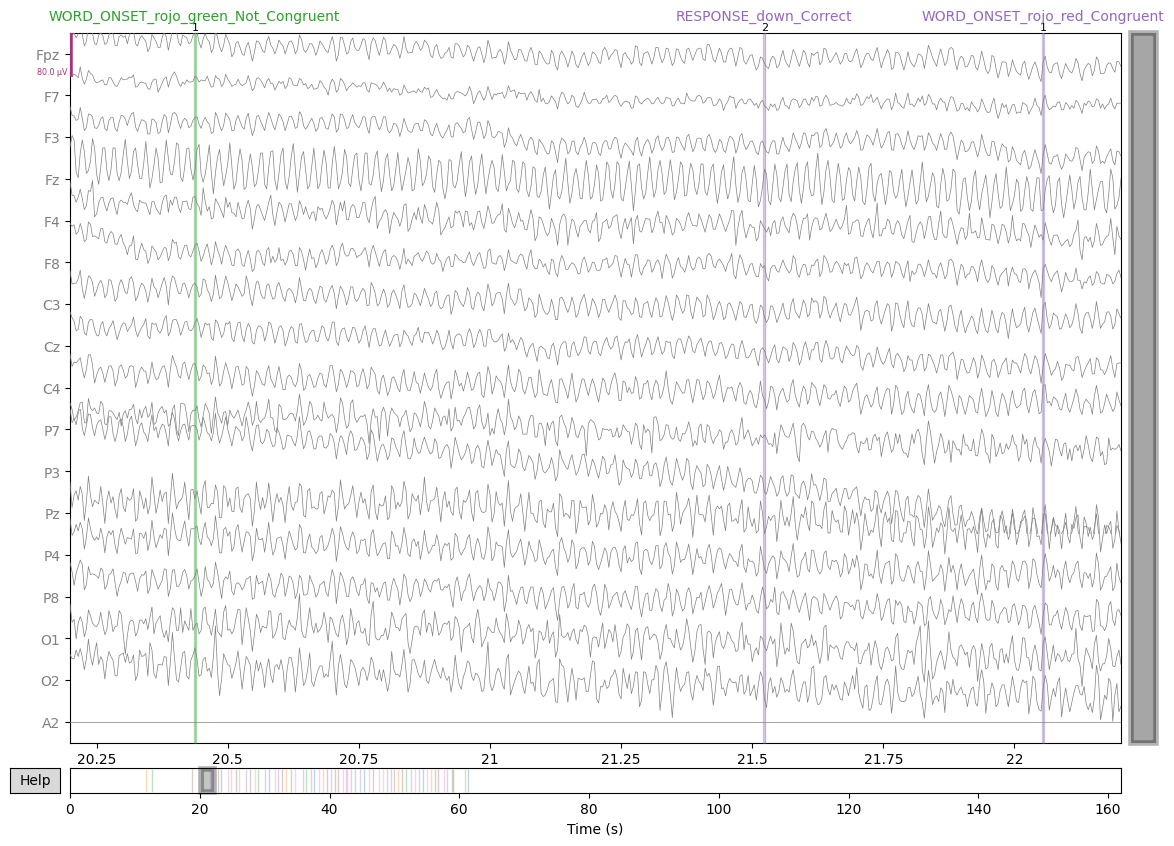

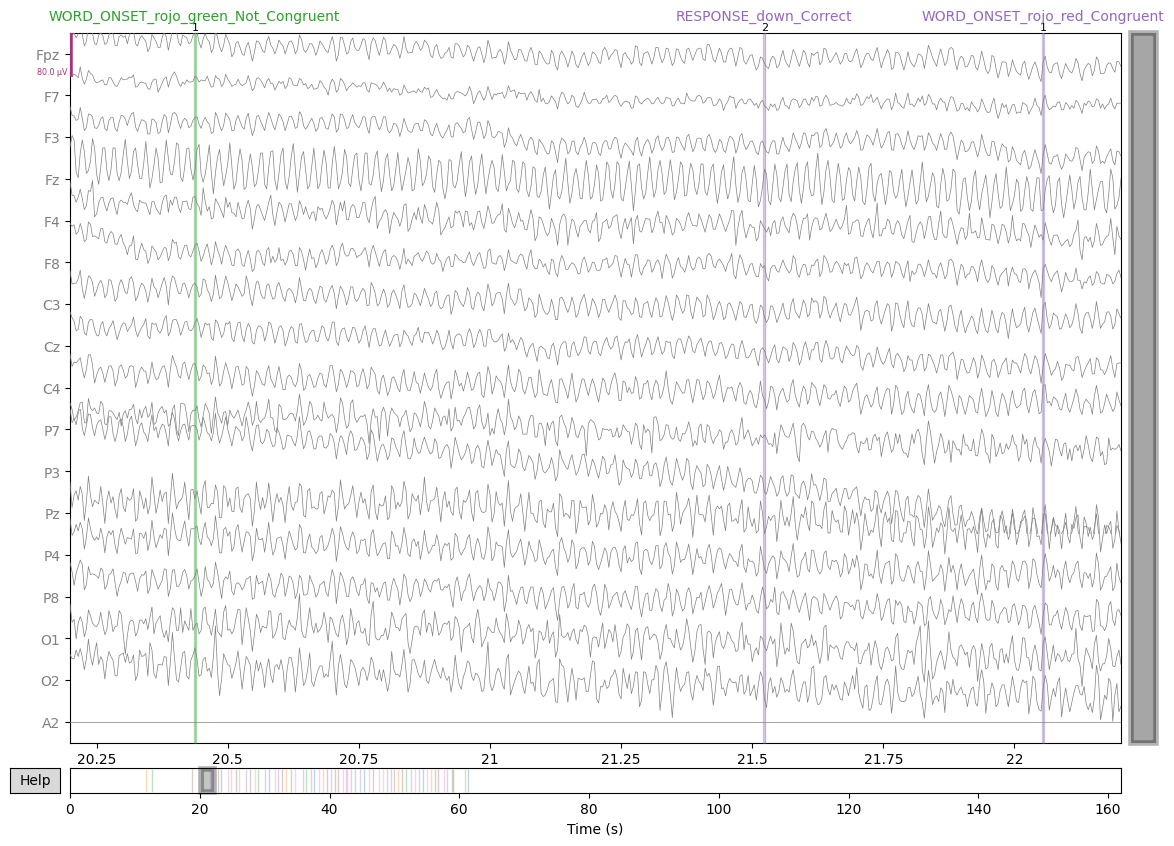

In [450]:
raw.plot(
    events=events1,
    start=20.2,
    duration=2,
    color="gray",
    scalings=0.00004
)